In [25]:
import sys
sys.path.insert(0, "../")

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from time import time
from astropy.table import Table

from sklearn.datasets import load_iris
from mcfa import (mcfa, mpl_utils, utils)

%matplotlib inline

In [2]:
apogee = Table.read("../catalogs/tc-apogee-dr12-regularized-release.fits")

In [11]:
N = 10000 # subsample the data for testing

np.random.seed(42)

label_names = [ln for ln in apogee.dtype.names if ln.endswith("_H") and not ln.startswith(("E_", "PARAM_", "SRC_"))]
print("\n".join(label_names))

X = np.array([apogee[ln] for ln in label_names]).T

ok = apogee["R_CHI_SQ"] < 3
X = X[ok]

if N is not None and N < X.shape[0]:
    print("Sub-sampling {} stars".format(N))
    idx = np.random.choice(X.shape[0], N, replace=False)
    X = X[idx]

AL_H
CA_H
C_H
FE_H
K_H
MG_H
MN_H
NA_H
NI_H
N_H
O_H
SI_H
S_H
TI_H
V_H
Sub-sampling 10000 stars


In [12]:
J = 3 # number of latent factors
K = 5 # number of clusters

t_init = time()

model = mcfa.MCFA(n_latent_factors=J, n_components=K, n_init=1)
model.fit(X)

t_opt = time() - t_init

print("Took {:.0f}s to optimize. ll = {:.0f}".format(t_opt, model.log_likelihood_))

Took 5s to optimize. ll = 68694


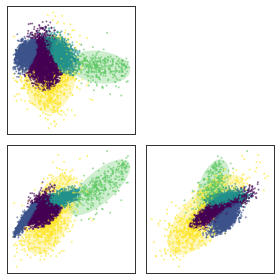

In [16]:
fig = model.plot_latent_space(X)

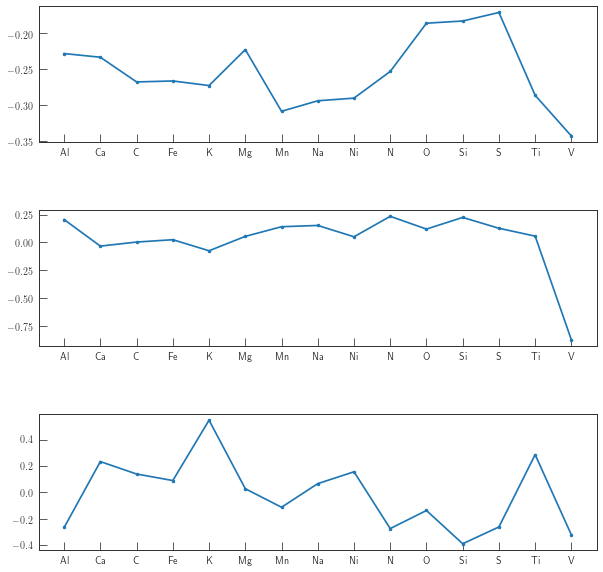

In [17]:
N, D = X.shape

latex_label_name = lambda ln: r"\textrm{{[{{{0}}}]}}".format("/".join([ln.split("_")[0].title(), ln.split("_")[1].upper()]))
latex_label_name = lambda ln: ln.split("_")[0].title()
                               
A = model.theta_[model.parameter_names.index("A")]
fig, axes = plt.subplots(model.n_latent_factors, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.plot(A.T[i])
    ax.set_xticks(np.arange(D))
    ax.set_xticklabels([latex_label_name(ln) for ln in label_names])

[Text(0,0,'Al'),
 Text(0,0,'Ca'),
 Text(0,0,'C'),
 Text(0,0,'Fe'),
 Text(0,0,'K'),
 Text(0,0,'Mg'),
 Text(0,0,'Mn'),
 Text(0,0,'Na'),
 Text(0,0,'Ni'),
 Text(0,0,'N'),
 Text(0,0,'O'),
 Text(0,0,'Si'),
 Text(0,0,'S'),
 Text(0,0,'Ti'),
 Text(0,0,'V')]

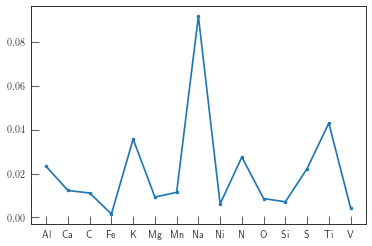

In [19]:
psi = model.theta_[model.parameter_names.index("psi")]
fig, ax = plt.subplots()
ax.plot(psi)
ax.set_xticks(np.arange(psi.size))
ax.set_xticklabels([latex_label_name(ln) for ln in label_names])

In [22]:
N, D = X.shape
print(N, D)

# Do some grid search in J, K
Js = np.arange(1, 10 + 1).astype(int)
Ks = np.arange(1, 30 + 1).astype(int)

# TODO: Should we use some approximation to estimate how long it will take?

BICs = np.nan * np.ones((Js.size, Ks.size))
opt_times = np.nan * np.ones((Js.size, Ks.size))
log_likelihoods = np.nan * np.ones((Js.size, Ks.size))

write_results = True
results_path = "results/apogee-gridsearch-J{J}-K{K}.pkl"

results_folder = os.path.dirname(results_path)
if not os.path.exists(results_folder):
    os.mkdir(results_folder)

mcfa_kwds = dict(max_iter=10000, n_init=5, tol=1e-5, verbose=0,
                 random_seed=None)

10000 15


In [26]:
c, C = (0, Js.size * Ks.size)

for k, K in enumerate(Ks):
    for j, J in enumerate(Js):
        
        c += 1
        print("{}/{}: J = {}, K = {}".format(c, C, J, K))
        if np.isfinite(BICs[j, k]):
            print("Skipping..")
            continue
        
        kwds = mcfa_kwds.copy()
        kwds.update(n_components=K, n_latent_factors=J)
        
        model = mcfa.MCFA(**kwds)
        
        t_init = time()
        try:
            model.fit(X)
            
        except:
            logger.exception("Exception in fitting at J = {}, K = {}".format(J, K))
            opt_times[j, k] = np.nan
            BICs[j, k] = np.nan
            log_likelihoods[j, k] = np.nan
            continue
            
        t_opt = time() - t_init
        
        # Save results.
        opt_times[j, k] = t_opt
        BICs[j, k] = model.bic(X)
        log_likelihoods[j, k] = model.log_likelihood_                     
        
        if write_results:
            result = dict(kwds=kwds,
                          t_opt=t_opt,
                          bic=BICs[j, k],
                          tau=model.tau_,
                          theta=model.theta_,
                          n_iter=model.n_iter_, 
                          log_likelihood=model.log_likelihood_)
            
            path = results_path.format(J=J, K=K)
            with open(path, "wb") as fp:
                pickle.dump(result, fp, -1)

            print("Results written to {}".format(path))



1/300: J = 1, K = 1
Skipping..
2/300: J = 2, K = 1
Results written to results/apogee-gridsearch-J2-K1.pkl
3/300: J = 3, K = 1
Results written to results/apogee-gridsearch-J3-K1.pkl
4/300: J = 4, K = 1
Results written to results/apogee-gridsearch-J4-K1.pkl
5/300: J = 5, K = 1
Results written to results/apogee-gridsearch-J5-K1.pkl
6/300: J = 6, K = 1
Results written to results/apogee-gridsearch-J6-K1.pkl
7/300: J = 7, K = 1
Results written to results/apogee-gridsearch-J7-K1.pkl
8/300: J = 8, K = 1
Results written to results/apogee-gridsearch-J8-K1.pkl
9/300: J = 9, K = 1
Results written to results/apogee-gridsearch-J9-K1.pkl
10/300: J = 10, K = 1
Results written to results/apogee-gridsearch-J10-K1.pkl
11/300: J = 1, K = 2
Results written to results/apogee-gridsearch-J1-K2.pkl
12/300: J = 2, K = 2
Results written to results/apogee-gridsearch-J2-K2.pkl
13/300: J = 3, K = 2
Results written to results/apogee-gridsearch-J3-K2.pkl
14/300: J = 4, K = 2
Results written to results/apogee-gridsear

Results written to results/apogee-gridsearch-J9-K11.pkl
110/300: J = 10, K = 11
Results written to results/apogee-gridsearch-J10-K11.pkl
111/300: J = 1, K = 12
Results written to results/apogee-gridsearch-J1-K12.pkl
112/300: J = 2, K = 12
Results written to results/apogee-gridsearch-J2-K12.pkl
113/300: J = 3, K = 12
Results written to results/apogee-gridsearch-J3-K12.pkl
114/300: J = 4, K = 12
Results written to results/apogee-gridsearch-J4-K12.pkl
115/300: J = 5, K = 12
Results written to results/apogee-gridsearch-J5-K12.pkl
116/300: J = 6, K = 12
Results written to results/apogee-gridsearch-J6-K12.pkl
117/300: J = 7, K = 12
Results written to results/apogee-gridsearch-J7-K12.pkl
118/300: J = 8, K = 12
Results written to results/apogee-gridsearch-J8-K12.pkl
119/300: J = 9, K = 12
Results written to results/apogee-gridsearch-J9-K12.pkl
120/300: J = 10, K = 12
Results written to results/apogee-gridsearch-J10-K12.pkl
121/300: J = 1, K = 13
Results written to results/apogee-gridsearch-J1-

Results written to results/apogee-gridsearch-J3-K22.pkl
214/300: J = 4, K = 22
Results written to results/apogee-gridsearch-J4-K22.pkl
215/300: J = 5, K = 22
Results written to results/apogee-gridsearch-J5-K22.pkl
216/300: J = 6, K = 22
Results written to results/apogee-gridsearch-J6-K22.pkl
217/300: J = 7, K = 22
Results written to results/apogee-gridsearch-J7-K22.pkl
218/300: J = 8, K = 22
Results written to results/apogee-gridsearch-J8-K22.pkl
219/300: J = 9, K = 22
Results written to results/apogee-gridsearch-J9-K22.pkl
220/300: J = 10, K = 22
Results written to results/apogee-gridsearch-J10-K22.pkl
221/300: J = 1, K = 23
Results written to results/apogee-gridsearch-J1-K23.pkl
222/300: J = 2, K = 23
Results written to results/apogee-gridsearch-J2-K23.pkl
223/300: J = 3, K = 23
Results written to results/apogee-gridsearch-J3-K23.pkl
224/300: J = 4, K = 23
Results written to results/apogee-gridsearch-J4-K23.pkl
225/300: J = 5, K = 23
Results written to results/apogee-gridsearch-J5-K2

In [27]:
def scatter_grid_search(Js, Ks, Zs, z_percentiles=None, cbar_label=None,
                        figsize=(10, 10), highlight_z_index=None, **kwargs):

    Jm, Km = np.meshgrid(Js, Ks)
    x, y = (Jm.flatten(), Km.flatten())
    z = Zs.T.flatten()

    kwds = dict(s=10, cmap="viridis")
    if z_percentiles is not None:
        vmin, vmax = np.nanpercentile(z, z_percentiles)
        kwds.update(vmin=vmin, vmax=vmax)
    
    kwds.update(kwargs)
    
    fig, ax = plt.subplots(figsize=figsize)
    scat = ax.scatter(x, y, c=z, **kwds)
    
    ax.set_xlabel(r"$J$")
    ax.set_ylabel(r"$K$")
    
    if cbar_label is not None:
        cbar = plt.colorbar(scat)
        cbar.set_label(cbar_label)
        
    ax.set_xticks(np.unique(x).astype(int))
    ax.set_xticklabels(np.unique(x).astype(str))
    
    if highlight_z_index is not None:
        ok = np.where(np.isfinite(z))[0]
        
        indices = ok[np.argsort(z[ok])][highlight_z_index]
        ax.scatter(x[indices], y[indices], zorder=-1,
                   s=100, lw=5, edgecolor="r", facecolor="none")
        
    
    fig.tight_layout()
    return fig


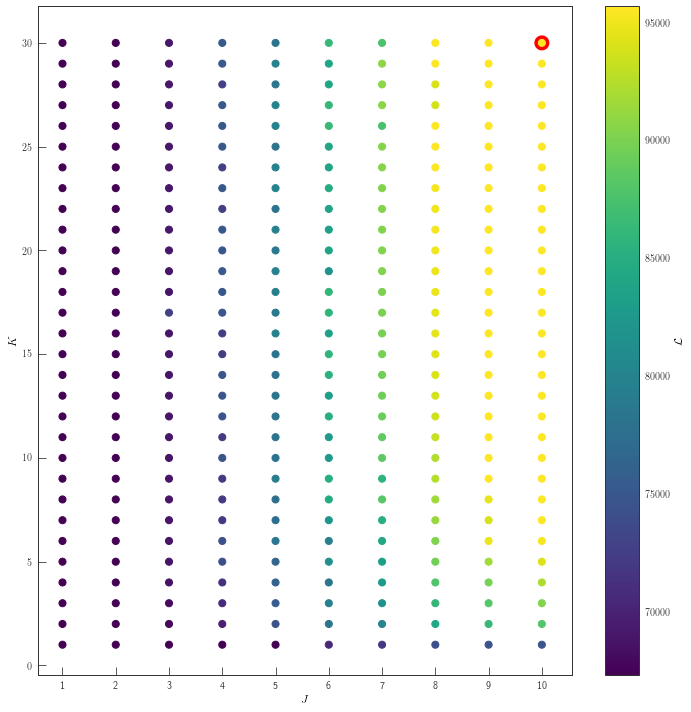

In [28]:
fig = scatter_grid_search(Js, Ks, log_likelihoods, s=50,
                          z_percentiles=[16, 84], cbar_label=r"$\mathcal{L}$",
                          highlight_z_index=-1)

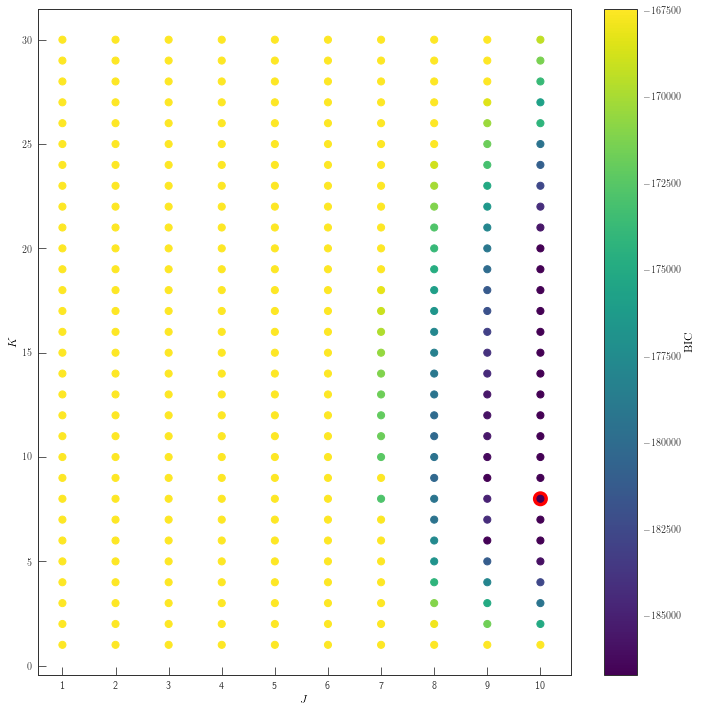

In [29]:
fig = scatter_grid_search(Js, Ks, BICs, s=50,
                          z_percentiles=[5, 30], cbar_label=r"\textrm{BIC}",
                          highlight_z_index=0)